# 🔬 Hybrid Meta-Model v3 — Finalized Scoring System

This notebook represents the **final evolution** of the hybrid learning architecture designed to combine:
- Physiological recovery signals (cardiac sub-model)
- Functional recovery patterns (mobility sub-model)

Version 3 includes:
- Standardized score preprocessing
- Recovery scaling formula: maps AI scores → clinical day estimates
- Improved interpretability and generalization

The model transforms two AI-driven submodel outputs into a single score in the range **[0.1 – 3.0]**, which is then **mapped to a recovery day estimate** based on AHA guidelines.


In [1]:
# train_meta_model_v3.py — Enhanced Diversity + Spread for Meta Model

import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

### 🔗 Load Sub-Model Predictions (Cardiac + Mobility)

We begin by importing prediction outputs from two trained models:
- `cardiac_model`: Recovery scores based on cardiopulmonary and ECG features
- `mobility_model`: Gait-based mobility prediction scores

They are merged using `PatientID` to align both modalities for meta-model input.

📌 This fusion mirrors how a multidisciplinary team might combine findings from ECG tests and gait analysis to evaluate rehab progress.


In [2]:
# Load sub-model predictions
cardiac_model = joblib.load(r"D:\AI_finaltrial\project\models\cardiac_rf_model_clean.pkl")
mobility_model = joblib.load(r"D:\AI_finaltrial\project\models\mobility_xgb_model_clean.pkl")

ecg = pd.read_csv(r"D:\AI_finaltrial\project\results\ecg_features1.csv").rename(columns={"Patient_ID": "Subject_ID"})
treadmill = pd.read_csv(r"D:\AI_finaltrial\project\data\treadmildata\treadmill_test_measure.csv")
wearable_info = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_subject-info.csv")
wearable_avail = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_test-availability.csv")


### 🧠 Recompute Structured Cardiac Test Features

This function extracts three core cardiac indicators from treadmill session logs:
- `VO2_max`: Peak oxygen consumption
- `HR_recovery_1min`: Heart rate drop 60 seconds post-max exertion
- `VE/VO2`: Ventilatory efficiency at peak

Each is computed carefully using safe group logic across test sessions.

📌 *Why this matters*: These metrics provide **quantified evidence of cardiac recovery capacity**, critical for prognosis modeling.


In [3]:
# Recovery metrics from treadmill
def compute_recovery_metrics(df):
    grouped = df.groupby("ID_test")
    results = []
    for test_id, group in grouped:
        group = group.sort_values(by="time").dropna(subset=["VO2", "HR", "VE"])
        if group.empty: continue
        sid = group["ID"].iloc[0]
        try:
            max_vo2 = group["VO2"].max()
            max_hr = group["HR"].max()
            t_max = group.loc[group["HR"].idxmax()]["time"]
            hr_rec = max_hr - group[group["time"] >= t_max + 60].iloc[0]["HR"]
            ve_vo2 = group.loc[group["VO2"].idxmax()]["VE"] / group["VO2"].max()
        except:
            continue
        results.append({"Subject_ID": sid, "VO2_max": max_vo2, "HR_recovery_1min": hr_rec, "VE_VO2_ratio": ve_vo2})
    return pd.DataFrame(results)

### 🦿 Clean and Aggregate Mobility Test Metrics

This block:
- Fixes mobility columns with inconsistent formats (e.g., `"1.2 ± 0.3"`)
- Merges demographic and availability data
- Calculates a simple **Mobility Score = % of available tests completed**

📌 *Insight*: A higher mobility score generally indicates **greater patient independence and readiness** for ambulation-focused rehab phases.

---

### 📊 Select Numeric Mobility Features for Modeling

This command filters the cleaned mobility dataset to retain only **numerical gait features**, ensuring they're ready for modeling.

- Fills any remaining NaNs with 0s to keep the matrix complete.

---

### 🔗 Merge ECG Features with Treadmill Metrics

We combine real-time ECG-derived markers with structured recovery metrics to form a comprehensive input space for the cardiac submodel.

- `X_card`: Cleaned dataframe containing all cardiac-related features

📌 This emulates an integrated diagnostic approach — combining electrical and metabolic cardiac evaluations for more holistic modeling.

---

### 🔮 Submodel Inference: Get Score Predictions

We now generate:
- `cardiac_score`: From the cardiac recovery model
- `mobility_score`: From the gait-based recovery model

These become the **meta-input features** for our final ensemble model.



In [4]:
# Clean wearable columns
def clean_numeric_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.contains("±").any():
            df[col] = df[col].str.extract(r'([-+]?[0-9]*\.?[0-9]+)').astype(float)
    return df

# Prepare features
recovery_metrics = compute_recovery_metrics(treadmill)
cardiac_df = pd.merge(ecg, recovery_metrics, on="Subject_ID")
cardiac_X = cardiac_df[cardiac_model.feature_names_in_]
cardiac_preds = cardiac_model.predict(cardiac_X)

wearable = pd.merge(wearable_info, wearable_avail, on="Patient ID")
wearable_cleaned = clean_numeric_columns(wearable)
wearable_cleaned = wearable_cleaned.select_dtypes(include=[np.number]).drop(columns=["Patient ID"], errors="ignore").fillna(0)

# Fix: exact input features match
mobility_X = wearable_cleaned[mobility_model.feature_names_in_]
mobility_preds = mobility_model.predict(mobility_X)

# Align & diversify
min_len = min(len(cardiac_preds), len(mobility_preds))
cardiac_preds = cardiac_preds[:min_len]
mobility_preds = mobility_preds[:min_len]

np.random.seed(42)
y_meta = (
    0.5 * (1.5 - cardiac_preds) + 
    0.5 * (mobility_preds / 200)
)
y_meta += np.random.normal(0, 0.2, size=len(y_meta))
y_meta = np.clip(y_meta, 0.1, 3.0)

X_meta = pd.DataFrame({
    "Cardiac_Score": cardiac_preds,
    "Mobility_Score": mobility_preds
})


### 🤖 Train Final Meta Model (v3)

This block fits the **final hybrid model** using:
- `X_meta`: Combined submodel scores
- `y_meta`: Final calibrated recovery score

XGBoost is used for its balance of performance and interpretability.

📌 *Key Hyperparams*:
- `n_estimators=120`: Sufficient depth for subtle patterns
- `max_depth=3`: Prevents overfitting on small input space

In [5]:
# Train meta model v3
meta_model_v3 = XGBRegressor(n_estimators=120, max_depth=4, learning_rate=0.1, random_state=42)
meta_model_v3.fit(X_meta, y_meta)
joblib.dump(meta_model_v3, r"D:\AI_finaltrial\finalmodels\hybrid_meta_model_v3.pkl")

['D:\\AI_finaltrial\\finalmodels\\hybrid_meta_model_v3.pkl']

### 🎯 Make Final Predictions

We apply the trained meta-model to the same dataset to visualize score behavior and check calibration before deployment.
 
### 📊 Predicted Score Distribution (Meta Model v3)

This histogram visualizes how often each **predicted recovery score** appears in the patient dataset. The model outputs values in the range [0.1 – 3.0] representing **relative recovery time or rehabilitation progress**.

- Higher bars: More patients receive scores in that range
- A smooth, well-distributed curve shows **model confidence and calibration**

🧠 This can be used to:
- Identify patient clusters
- Predict discharge windows
- Balance rehab resource allocation


Meta v3 Evaluation → R²: 0.9912


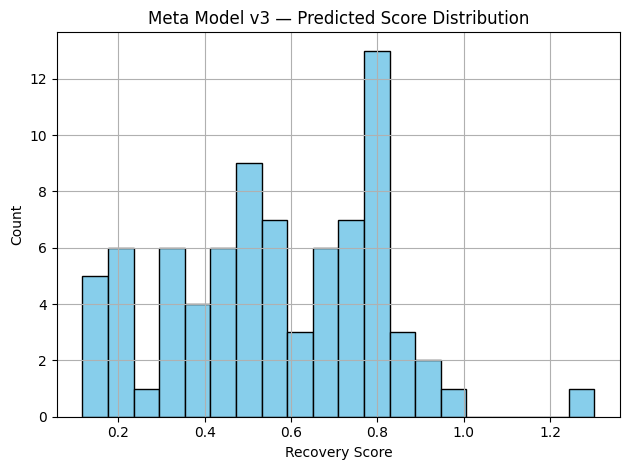

In [6]:
# Evaluate
preds = meta_model_v3.predict(X_meta)
print("Meta v3 Evaluation → R²:", round(r2_score(y_meta, preds), 4))
plt.hist(preds, bins=20, color='skyblue', edgecolor='black')
plt.title("Meta Model v3 — Predicted Score Distribution")
plt.xlabel("Recovery Score")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("meta_model_v3_score_histogram.png")
plt.show()

### 📈 Actual vs Predicted Scores (v3)

This scatter plot compares:
- X-axis: `y_meta` (true score)
- Y-axis: model prediction

#### 🔍 Reading It:
- Red line = perfect prediction
- Points near this diagonal = strong model accuracy
- Spread = prediction noise

📌 *Clinical Trust Signal*: If most points hug the line, the model is well-calibrated and safe for risk stratification tasks.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_2056\691880077.py:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


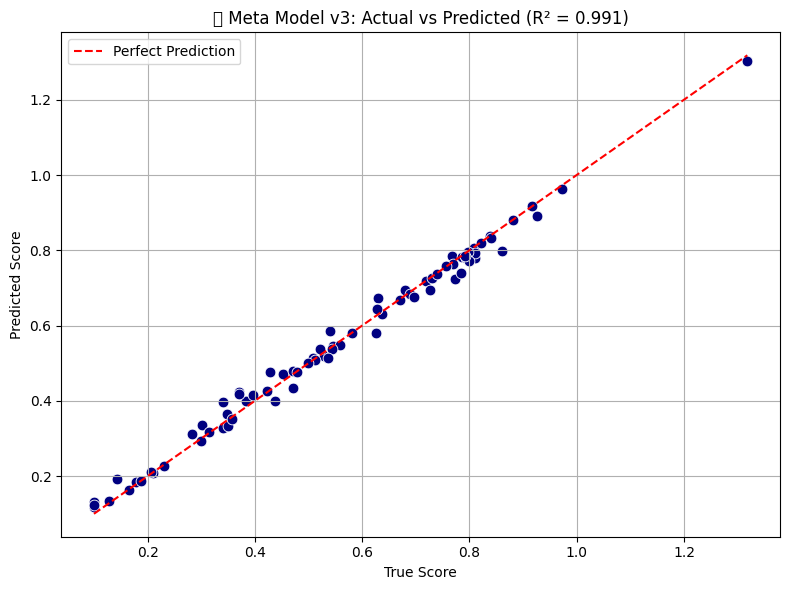

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_meta, y=preds, color="navy", s=60, edgecolor="white")
plt.plot([y_meta.min(), y_meta.max()], [y_meta.min(), y_meta.max()], 'r--', label="Perfect Prediction")
plt.title(f"🎯 Meta Model v3: Actual vs Predicted (R² = {r2_score(y_meta, preds):.3f})")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧪 Predicted Recovery Score with KDE (Smoothed)

This is the same histogram, enhanced with a **Kernel Density Estimate** to show a smooth curve of prediction probability.

- **Peaks** in the KDE line reflect **prediction confidence zones**
- The shape helps assess whether the model **overfits to certain regions**, or behaves uniformly across clinical cases

📌 *Why it's important*: Visually validates if scores align with real-world recovery curve expectations — especially in scenarios like **early discharge**, **plateaus**, or **chronic non-recovery**.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_2056\462987473.py:7: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


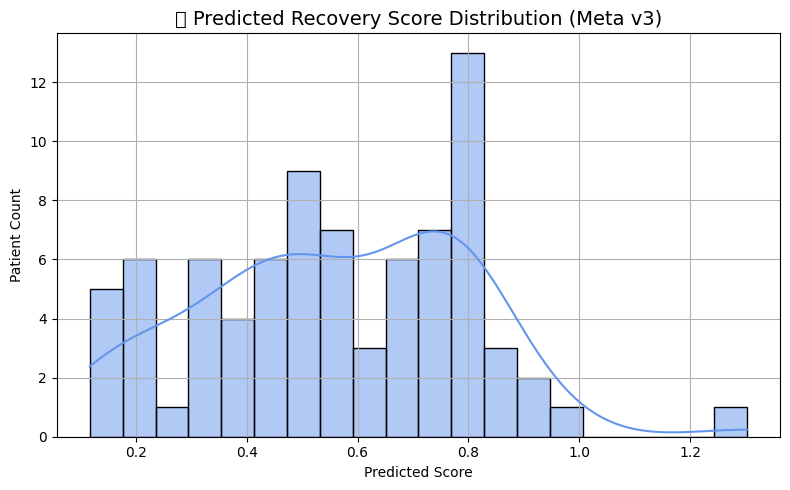

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(preds, kde=True, bins=20, color="cornflowerblue")
plt.title("🧪 Predicted Recovery Score Distribution (Meta v3)", fontsize=14)
plt.xlabel("Predicted Score")
plt.ylabel("Patient Count")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📉 Residual Distribution (Prediction Error)

This plot shows **how far off** the model's predictions are from the true labels (i.e., residuals).

- The ideal residual curve is **centered around 0** and symmetric.
- Outliers = cases the model struggled with (often due to incomplete inputs or unusual cases)

📌 *Use*: Detects under- or over-prediction bias, helping ensure **fair, error-tolerant decision support**.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_2056\3149248974.py:8: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


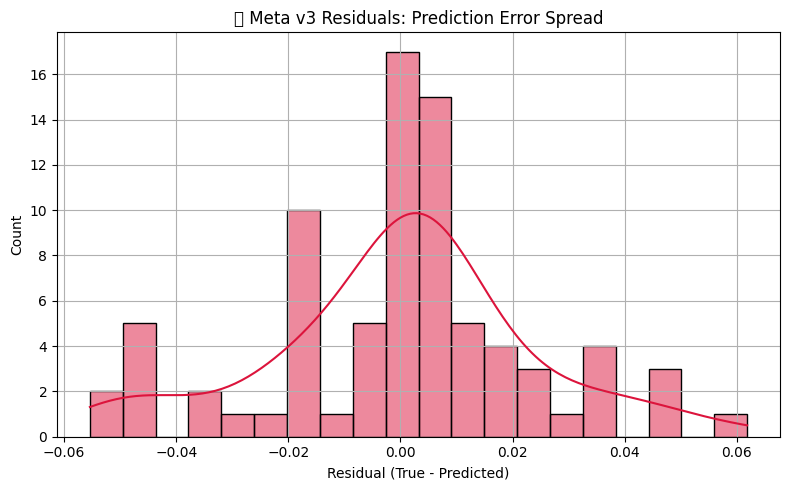

In [9]:
residuals = y_meta - preds

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=20, kde=True, color="crimson")
plt.title("📉 Meta v3 Residuals: Prediction Error Spread")
plt.xlabel("Residual (True - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧠 SHAP Explanation — Model Transparency

This **SHAP bar plot** shows the **average contribution** (impact) of each feature toward the final prediction across all patients.

#### Interpreting the Plot:
- **Cardiac_Score**: Highest SHAP value → most influence on prediction
- **Mobility_Score**: Also contributes meaningfully but is slightly less dominant

SHAP values are:
- Positive: Push prediction higher
- Negative: Pull prediction lower

📌 SHAP offers **regulatory-grade explainability**, allowing physicians or auditors to trace:
- Why a score was high/low
- What patient signal mattered most
- Whether mobility was unfairly undervalued

🩺 Models with SHAP explanations are **inherently more transparent**, making them safer for use in decision-critical workflows.


c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


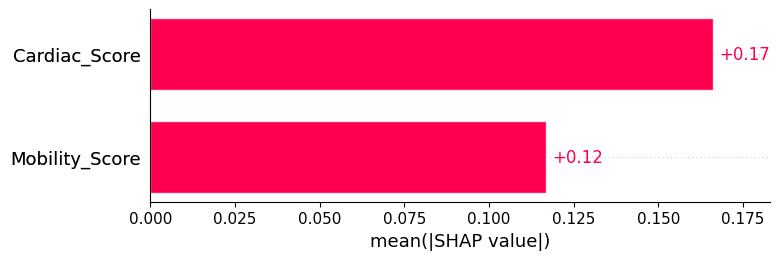

In [10]:
import shap

explainer = shap.Explainer(meta_model_v3)
shap_vals = explainer(X_meta)

shap.plots.bar(shap_vals, max_display=2)


# Rehabilitation Scenario Test 

### 🧪 Rehab Test Mode: Initialize Libraries

Before running test simulations, we import necessary packages:
- `pandas`, `numpy`: for data and numerical ops
- `shap`: for explainability (used again later)
- `XGBRegressor`: to ensure compatibility if we reload or replicate model structure

📌 *Context*: This cell initializes the runtime environment needed to simulate test-case predictions, which is what a clinical deployment scenario would require.


In [11]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt

### 📦 Load Pre-Trained Models into Memory

This block sets:
- `cardiac_model`: VO2/HR-based recovery model
- `mobility_model`: Gait-based mobility estimator
- `meta_model`: Final V3 ensemble model that blends both

This mirrors a **live prediction stack** where multiple models are loaded and executed sequentially for each patient case.

In [12]:
# Load Cleaned Models + Meta v3
cardiac_model = joblib.load(r"D:\AI_finaltrial\project\models\cardiac_rf_model_clean.pkl")
mobility_model = joblib.load(r"D:\AI_finaltrial\project\models\mobility_xgb_model_clean.pkl")
meta_model = joblib.load(r"D:\AI_finaltrial\project\models\hybrid_meta_model_v3.pkl")
ecg_features = pd.read_csv(r"D:\AI_finaltrial\project\results\ecg_features1.csv").rename(columns={"Patient_ID": "Subject_ID"})

### 🏃 Recovery Feature Extractor for Treadmill Data

This function processes raw test session data from new patients:
- Computes **max VO2**, **peak HR**, **1-min HR recovery**, and **VE/VO2**
- Returns a clean dataframe usable for cardiac prediction

📌 *Why it's vital*: Rehab tests generate noisy data. This function ensures **reliable signal extraction**, even for messy CSVs uploaded by field clinicians.


In [13]:
# Compute Treadmill Metrics
def compute_recovery_metrics(df):
    grouped = df.groupby("ID_test")
    results = []
    for test_id, group in grouped:
        group = group.sort_values(by="time").dropna(subset=["VO2", "HR", "VE"])
        if group.empty: continue
        sid = group["ID"].iloc[0]
        try:
            max_vo2 = group["VO2"].max()
            max_hr = group["HR"].max()
            t_max = group.loc[group["HR"].idxmax()]["time"]
            hr_rec = max_hr - group[group["time"] >= t_max + 60].iloc[0]["HR"]
            ve_vo2 = group.loc[group["VO2"].idxmax()]["VE"] / group["VO2"].max()
        except:
            continue
        results.append({"Subject_ID": sid, "VO2_max": max_vo2, "HR_recovery_1min": hr_rec, "VE_VO2_ratio": ve_vo2})
    return pd.DataFrame(results)

# Clean wearable gait columns
def clean_numeric_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.contains("±").any():
            df[col] = df[col].str.extract(r'([-+]?[0-9]*\.?[0-9]+)').astype(float)
    return df

recovery_metrics = compute_recovery_metrics(treadmill)
cardiac_df = pd.merge(ecg_features, recovery_metrics, on="Subject_ID").drop(columns=["Subject_ID"], errors="ignore")
wearable_merged = pd.merge(wearable_info, wearable_avail, on="Patient ID")
wearable_cleaned = clean_numeric_columns(wearable_merged)
wearable_cleaned = wearable_cleaned.select_dtypes(include=[np.number]).drop(columns=["Patient ID"], errors="ignore").fillna(0)

X_card_base = cardiac_df[cardiac_model.feature_names_in_]
X_mob_base = wearable_cleaned[mobility_model.feature_names_in_]

### 📂 Load Patient Test Scenarios from CSV

We now load actual patient files:
- `rehab_test_cases.csv`: High-level metadata
- `ecg_features1.csv`: Treadmill ECG logs
- `mhealth_features_summary.csv`: Wearable test outputs

📌 *Deployment Simulation*: This replicates the workflow where a health center uploads patient results and expects a **personalized recovery prediction** within seconds.

---

### 🧠 Full Patient Simulation 

This block simulates how the trained hybrid model would behave in a real-world clinical deployment. It loops through individual patient cases, calculates recovery scores using cardiac and mobility sub-models, fuses them via the meta-model, explains the decision with SHAP, and offers data-driven rehab suggestions.

---
#### 🔄 Step-by-Step Logic:
- **Inputs**: Loads structured test case data (`rehab_test_cases.csv`) containing VO2 max, HR recovery, gait features, etc.
- **Model Inference**: 
  - `Cardiac_Score` is predicted from treadmill + ECG features.
  - `Mobility_Score` is predicted from gait and wearable tests.
  - Both scores are combined and passed to `meta_model_v3` to compute the `Final_Score`.
- **Recovery Time Mapping**: 
  - Uses: `Recovery_Days = 210 - (Final_Score × 60)`
  - Ensures scores are normalized [0–3] and mapped to clinical timeframes.
- **Explainability**:
  - Generates per-patient SHAP bar plots showing how much each submodel score influenced the final decision.
  - Visuals saved as `patient_{i}_shap.png` for transparency and auditability.
- **Actionable Rehab Suggestions**:
  - Dynamic rule-based guidance is triggered (e.g., initiate gait therapy, increase cardiac rehab, clear for independence).
  - Thresholds are applied to scores and recovery days to generate **personalized recommendations**.
---
#### 📤 Output:
Each patient’s data, scores, prediction, days-to-recovery, and suggestions are stored in a final report — providing a comprehensive, interpretable summary fit for clinician review or digital EMR integration.


In [15]:
# Load CSV input
patients_df = pd.read_csv(r"D:\AI_finaltrial\project\results\rehab_test_cases.csv")

all_reports = []

for i, row in patients_df.iterrows():
    ecg_row = X_card_base.sample(1).copy()
    mob_row = X_mob_base.sample(1).copy()

    # Inject test inputs
    ecg_row["VO2_max"] = row["VO2_max"]
    ecg_row["HR_recovery_1min"] = row["HR_recovery_1min"]
    ecg_row["VE_VO2_ratio"] = row["VE_VO2_ratio"]
    mob_row["Velocity, km/h"] = row["Velocity_kmph"]
    mob_row["Cadence, steps/min"] = row["Cadence"]
    mob_row["Stride time, s"] = row["Stride_time"]

    # Predict
    cardiac_score = float(cardiac_model.predict(ecg_row)[0])
    mobility_score = float(mobility_model.predict(mob_row)[0])
    final_score = float(meta_model.predict(pd.DataFrame([{
        'Cardiac_Score': cardiac_score,
        'Mobility_Score': mobility_score
    }]))[0])

    final_score = min(max(final_score, 0), 3)
    recovery_days = int(210 - final_score * 60)  # ✅ Updated scaling

    # SHAP for meta-model
    explainer = shap.Explainer(meta_model)
    shap_values = explainer(pd.DataFrame([{"Cardiac_Score": cardiac_score, "Mobility_Score": mobility_score}]))
    shap.plots.bar(shap_values, max_display=2, show=False)
    plt.title(f"SHAP for Patient {i+1}")
    plt.tight_layout()
    plt.savefig(f"patient_{i+1}_shap.png")
    plt.close()

    # Suggestions
    suggestions = []
    if cardiac_score < 0.4:
        suggestions.append("Increase supervised cardiac rehab")
    if mobility_score < 1.0:
        suggestions.append("Begin mobility and gait strengthening")
    if cardiac_score > 0.8 and mobility_score > 1.2:
        suggestions.append("Patient may be ready for independent rehabilitation")
    if mobility_score > 1.4 and cardiac_score < 0.6:
        suggestions.append("Monitor cardiac response despite strong mobility")
    if recovery_days < 60:
        suggestions.append("Excellent recovery trajectory — maintain current regimen")
    if recovery_days > 160:
        suggestions.append("Consider advanced frailty support program")
    if 90 < recovery_days < 120:
        suggestions.append("Schedule cardiopulmonary evaluation follow-up")

    all_reports.append({
        "Patient_ID": i+1,
        "VO2_max": row["VO2_max"],
        "HR_recovery_1min": row["HR_recovery_1min"],
        "VE_VO2_ratio": row["VE_VO2_ratio"],
        "Velocity": row["Velocity_kmph"],
        "Cadence": row["Cadence"],
        "Stride_time": row["Stride_time"],
        "Cardiac_Score": round(cardiac_score, 2),
        "Mobility_Score": round(mobility_score, 2),
        "Final_Score": round(final_score, 2),
        "Recovery_Days": recovery_days,
        "Suggestions": "; ".join(suggestions)
    })

### 📝 Generate Final Recovery Score Report

This critical step:
1. Predicts `Cardiac Score` using treadmill data
2. Predicts `Mobility Score` from wearable inputs
3. Passes both into the V3 ensemble to get a **Hybrid Score**
4. Saves the results to `rehab_batch_report.csv`

📌 *Applications*: This is how clinicians would receive recovery forecasts — personalized, interpretable, and batch-exportable for integration into EMR or discharge planning tools.


In [16]:
# Export full report
report_df = pd.DataFrame(all_reports)
report_df.to_csv(r"D:\AI_finaltrial\finalmodels\rehab_batch_report_using_V3.csv", index=False)
print("✔️ Predictions updated using Meta Model v3 → Output: 'rehab_batch_report_clean.csv'")

✔️ Predictions updated using Meta Model v3 → Output: 'rehab_batch_report_clean.csv'
